## MLP Model

In [1]:
# importing useful libraries
import numpy as np
import tensorflow as tf
import random as python_random

# setting random seed for result reproducibility
np.random.seed(1)
python_random.seed(12)
tf.random.set_seed(123)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Metric, AUC
from keras.wrappers.scikit_learn import KerasClassifier

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# loading in the dataset
df = pd.read_csv('../input/creditcardfraud/creditcard.csv')
print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# 27 most important features according to our EDA
cols = ['V'+str(i) for i in range(1, 29) if i != 25]
print(cols)

['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V26', 'V27', 'V28']


In [4]:
# selecting the 19 most important features according to our EDA 
X = df[cols]

y = df['Class'] # selecting the target variable

In [5]:
val_count = df['Class'].value_counts()
weights = dict(1 / val_count) # to be used as class weights
weights

{0: 3.51722561243691e-06, 1: 0.0020325203252032522}

### Not using classw weight performed better than using class weight for the neural network. So, we would use class weight in for our neural network. 

## <center>Cost matrix for fraud detection</center>

||Actual Positive|Actual Negative|
|:-:|:-:|:-:|
|**Predicted Positive**|administrative cost|administrative cost|
|**Predicted Negative**|transactional cost|0|

### *see [this article](https://towardsdatascience.com/fraud-detection-with-cost-sensitive-machine-learning-24b8760d35d9) for more about cost sensitive machine learning for fraud detection*

In [6]:
admin_cost = 2.5

### our choice of using 2.5euros as the administartive cost because it seems to be the best for our problem as suggested by [this paper](https://www.researchgate.net/publication/262390835_Cost_Sensitive_Credit_Card_Fraud_Detection_Using_Bayes_Minimum_Risk)

## Also, implementing cost sensitive models for sklearn's classifier is challenging. It is as good as creating a new model from the scratch. For simplicity, we will not penalize our model of True Positives (although, the cost matrix suggests we should penalize it for true positives). This will mean that we are only penalizing MISCLASSIFICATIONS (trying to minimize costs due to misclassification and not cost in general).

In [7]:
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)

In [8]:
# defining a function to calculate cost savings
def cost_saving(ytrue, ypred, amount, threshold=0.5):
    ypred = ypred.flatten()
    fp = np.sum((ytrue == 0) & (ypred == 1))
    cost = np.sum(fp*admin_cost) + np.sum((amount[(ytrue == 1) & (ypred == 0)]))
    max_cost = np.sum((amount[(ytrue == 1)]))
    savings = 1 - (cost/max_cost)
    
    return savings

In [9]:
# defining a function to calculate cost saving per fold (splits) of our cv
def cost_saving_per_split(scores, x, y, cv_object):
    results = []
    for i, (_, test_ind) in zip(range(cv_object.n_splits), cv_object.split(x, y)):
        ypred = scores['estimator'][i].predict(x[test_ind])
        ytrue = y[test_ind]
        amount = df['Amount'].values[test_ind]
        results.append(cost_saving(ytrue, ypred, amount))
        
    return results

In [10]:
# defining a function to return a dataframe of metrics results for each fold in our cv
def get_metric_scores(scores, x, y=y, cv_object=cv):
    ind = ['split_'+str(n) for n in range(1, cv_object.n_splits+1)]
    
    scores_df = pd.DataFrame(index=ind)
    
    scores_df['f1_score'] = scores['test_f1']
    scores_df['auc_pr'] = scores['test_average_precision']
    scores_df['cost_savings'] = cost_saving_per_split(scores, x, y, cv_object)

    return scores_df

## Fraud Sensitive model (Not cost sensitive)

In [11]:
X['Amount'] = df['Amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, \
                                                    random_state=1)

In [12]:
train_amount = X_train.pop('Amount')
test_amount = X_test.pop('Amount')

### we will use sample weight to penalize our model accordingly. admin cost for FP and transactional cost (amount) for FN.

In [13]:
# train_sample_weights to be used for training set of cost sensitive-example dependent model to choose 
# best number of epoch
train_sample_weights = np.array([train_amount[ind] if fraud else admin_cost for ind, fraud in \
                                 y_train.items()])

# sample_weights to be used for cross validation of cost sensitive-example dependent model
sample_weights = np.array([df['Amount'][ind] if fraud else admin_cost for ind, fraud in enumerate(y)])

### We will **fit** our scaler on only the training set and not the testing set. However, we will use it to transform both training and testing set. This is the standard and will mimic what will happen when our model has been deployed for production.  

In [14]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### confirming that our train test split was stratified.

In [15]:
y_train.value_counts() / y_train.value_counts()[1]

0    577.875339
1      1.000000
Name: Class, dtype: float64

In [16]:
y_test.value_counts() / y_test.value_counts()[1]

0    577.878049
1      1.000000
Name: Class, dtype: float64

### we will be using the stateful f1score to monitor the training process due to the class imbalance.

In [17]:
threshold = 0.5

In [18]:
class StatefulBinaryFBeta(Metric):
    def __init__(self, name='stateful_binary_fbeta', beta=1, threshold=threshold, \
                 epsilon=1e-7, **kwargs):
        # initializing an object of the super class
        super(StatefulBinaryFBeta, self).__init__(name=name, **kwargs)

        # initializing state variables
        self.tp = self.add_weight(name='tp', initializer='zeros') # initializing true positives 
        
        # initializing actual positives
        self.actual_positive = self.add_weight(name='fp', initializer='zeros') 
        
        # initializing predicted positives
        self.predicted_positive = self.add_weight(name='fn', initializer='zeros') 

        # initializing other atrributes that wouldn't be changed for every object of this class
        self.beta_squared = beta**2 
        self.threshold = threshold
        self.epsilon = epsilon

    def update_state(self, ytrue, ypred, sample_weight=None):
        # casting ytrue and ypred as float dtype
        ytrue = tf.cast(ytrue, tf.float32)
        ypred = tf.cast(ypred, tf.float32)

        # setting values of ypred greater than the set threshold to 1 while those lesser to 0
        ypred = tf.cast(tf.greater_equal(ypred, tf.constant(self.threshold)), tf.float32)
        
        self.tp.assign_add(tf.reduce_sum(ytrue*ypred)) # updating true positives 
        self.predicted_positive.assign_add(tf.reduce_sum(ypred)) # updating predicted positive 
        self.actual_positive.assign_add(tf.reduce_sum(ytrue)) # updating actual positive 
    
    def result(self):
        self.precision = self.tp/(self.predicted_positive+self.epsilon) # calculates precision
        self.recall = self.tp/(self.actual_positive+self.epsilon) # calculates recall

        # calculating fbeta
        self.fb = (1+self.beta_squared)*self.precision*self.recall / (\
                                    self.beta_squared*self.precision + self.recall + self.epsilon)
    
        return self.fb

    def reset_states(self):
        self.tp.assign(0) # resets true positives to zero
        self.predicted_positive.assign(0) # resets predicted positives to zero
        self.actual_positive.assign(0) # resets actual positives to zero

In [19]:
stopper = EarlyStopping(monitor='val_stateful_binary_fbeta', patience=10, mode='max',
    restore_best_weights=True)

### we will initialize the output bias to reduce the number of epochs required to reach the best result. The value is obtained by the formula: $$b_{0} = log(pos/neg)$$
### See more about initial bias [here](http://karpathy.github.io/2019/04/25/recipe/#2-set-up-the-end-to-end-trainingevaluation-skeleton--get-dumb-baselines) on how to *initialize well*.

In [20]:
neg, pos = np.bincount(y)
print('negative class is {} in number, while positive is {}'.format(neg, pos))
initial_bias = np.log([pos/neg])
initial_bias

negative class is 284315 in number, while positive is 492


array([-6.35935934])

In [21]:
def build_model():
    model = Sequential()

    model.add(Dense(16, kernel_initializer='uniform', activation='relu'))
    
    model.add(Dropout(0.2))
    
    output_bias = tf.keras.initializers.Constant(initial_bias) 
    
    model.add(Dense(1, activation='sigmoid', bias_initializer=output_bias))
    
    binary_fbeta = StatefulBinaryFBeta()
    
    # compling model
    model.compile(loss='binary_crossentropy', metrics=[binary_fbeta], optimizer='adam')
    
    return model

In [22]:
pd.DataFrame(X_train).describe() # checking summary statistics of the training set

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
count,2.136050e+05,2.136050e+05,2.136050e+05,2.136050e+05,2.136050e+05,2.136050e+05,2.136050e+05,2.136050e+05,2.136050e+05,2.136050e+05,...,2.136050e+05,2.136050e+05,2.136050e+05,2.136050e+05,2.136050e+05,2.136050e+05,2.136050e+05,2.136050e+05,2.136050e+05,2.136050e+05
mean,-5.940957e-17,3.308696e-18,6.897645e-17,1.529951e-17,3.043342e-17,-1.889232e-17,-8.010986e-18,1.612683e-17,-3.156265e-17,8.410808e-18,...,-9.054135e-19,-5.238612e-18,-2.113350e-17,2.396591e-17,1.661657e-17,1.572363e-17,-1.202713e-17,-1.088575e-17,2.766176e-17,6.428637e-17
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,...,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,-2.894088e+01,-4.456820e+01,-3.193523e+01,-4.014707e+00,-8.223626e+01,-1.960776e+01,-3.506962e+01,-6.075432e+01,-1.225143e+01,-2.270814e+01,...,-1.114273e+01,-8.850321e+00,-7.157312e+01,-4.736572e+01,-1.507635e+01,-5.929492e+01,-4.681387e+00,-5.257815e+00,-5.589815e+01,-4.679943e+01
25%,-4.733905e-01,-3.681522e-01,-5.882749e-01,-5.987030e-01,-4.994077e-01,-5.759849e-01,-4.468419e-01,-1.724718e-01,-5.861799e-01,-4.937656e-01,...,-5.956755e-01,-5.603550e-01,-2.776918e-01,-3.095466e-01,-7.473996e-01,-2.634583e-01,-5.840125e-01,-6.787620e-01,-1.751815e-01,-1.606299e-01
50%,8.788754e-03,3.926317e-02,1.176945e-01,-1.491895e-02,-3.816713e-02,-2.054283e-01,3.156398e-02,1.888879e-02,-4.746015e-02,-8.456047e-02,...,-4.188847e-03,4.986193e-03,-8.184843e-02,-3.955578e-02,8.856053e-03,-1.960514e-02,6.810582e-02,-1.083539e-01,3.687607e-03,3.438213e-02
75%,6.738880e-01,4.913846e-01,6.773872e-01,5.247305e-01,4.434481e-01,2.984683e-01,4.577876e-01,2.719350e-01,5.433963e-01,4.211409e-01,...,5.963905e-01,5.636453e-01,1.749705e-01,2.535179e-01,7.285323e-01,2.373485e-01,7.244469e-01,4.999686e-01,2.257340e-01,2.377424e-01
max,1.257145e+00,1.351940e+01,6.198642e+00,1.179914e+01,2.516451e+01,5.493438e+01,9.709075e+01,1.660173e+01,1.422236e+01,2.192944e+01,...,6.015147e+00,6.861089e+00,5.177360e+01,3.699255e+01,1.447872e+01,3.571100e+01,7.568174e+00,7.299527e+00,7.830721e+01,1.026601e+02


### There seems to be outliers in the features. We will clip the outliers. We will arbitrarily define outliers as observations outside of 1st and 99th percentile. 

In [23]:
a = np.percentile(X_train, 1, axis=0) # gets the first percentile for each feature
print(a)

[-3.35598442 -3.04460642 -2.62121913 -2.20963993 -2.21329592 -1.59186443
 -2.4109432  -3.34728305 -2.23750133 -1.93404082 -2.05630581 -3.06949683
 -2.29228219 -2.92859939 -2.603519   -2.71920018 -1.5947911  -2.56010235
 -2.55195133 -2.05767956 -1.99254328 -2.2846169  -1.92864716 -2.73646004
 -2.09039498 -3.08719829 -2.64782724]


In [24]:
b = np.percentile(X_train, 99, axis=0) # gets the 99th percentile for each feature
print(b)

[1.14628284 2.32478379 1.80515679 3.00697944 2.46673385 3.14627676
 2.18638956 1.72372554 2.7168256  2.97689188 2.24576384 1.70334366
 2.52683632 2.24922413 2.1011149  2.14034939 2.72789116 2.46887937
 2.7897677  3.17114874 2.59954424 2.1093771  2.45618108 1.75797563
 2.40431567 2.29949433 1.62894844]


In [25]:
# clipping
X_train = np.clip(X_train, a, b)
X_test = np.clip(X_test, a, b)

In [26]:
print(X_train.min(axis=0)) # confirming the new minimum values are now the 1st percentile
print()
print(X_train.max(axis=0)) # confirming the new maximum values are now the 99th percentile

[-3.35598442 -3.04460642 -2.62121913 -2.20963993 -2.21329592 -1.59186443
 -2.4109432  -3.34728305 -2.23750133 -1.93404082 -2.05630581 -3.06949683
 -2.29228219 -2.92859939 -2.603519   -2.71920018 -1.5947911  -2.56010235
 -2.55195133 -2.05767956 -1.99254328 -2.2846169  -1.92864716 -2.73646004
 -2.09039498 -3.08719829 -2.64782724]

[1.14628284 2.32478379 1.80515679 3.00697944 2.46673385 3.14627676
 2.18638956 1.72372554 2.7168256  2.97689188 2.24576384 1.70334366
 2.52683632 2.24922413 2.1011149  2.14034939 2.72789116 2.46887937
 2.7897677  3.17114874 2.59954424 2.1093771  2.45618108 1.75797563
 2.40431567 2.29949433 1.62894844]


### The arrays above are same as 1st and 99th percentile respectively.

### Now, we will use train test split to get the best number of epochs 

In [27]:
model = build_model()
history = model.fit(X_train, y_train, epochs=30, batch_size=512, callbacks=[stopper], \
                validation_data=(X_test, y_test), verbose=1)

Epoch 1/30
418/418 [==============================] - 2s 4ms/step - loss: 0.0060 - stateful_binary_fbeta: 0.5663 - val_loss: 0.0026 - val_stateful_binary_fbeta: 0.8692
Epoch 2/30
418/418 [==============================] - 2s 4ms/step - loss: 0.0037 - stateful_binary_fbeta: 0.7447 - val_loss: 0.0023 - val_stateful_binary_fbeta: 0.8776
Epoch 3/30
418/418 [==============================] - 1s 3ms/step - loss: 0.0035 - stateful_binary_fbeta: 0.7470 - val_loss: 0.0022 - val_stateful_binary_fbeta: 0.8833
Epoch 4/30
418/418 [==============================] - 1s 3ms/step - loss: 0.0034 - stateful_binary_fbeta: 0.7669 - val_loss: 0.0021 - val_stateful_binary_fbeta: 0.8852
Epoch 5/30
418/418 [==============================] - 1s 3ms/step - loss: 0.0034 - stateful_binary_fbeta: 0.7504 - val_loss: 0.0022 - val_stateful_binary_fbeta: 0.8571
Epoch 6/30
418/418 [==============================] - 1s 3ms/step - loss: 0.0033 - stateful_binary_fbeta: 0.7504 - val_loss: 0.0021 - val_stateful_binary_fbeta:

### Let's check the best f1 score and confirm it using sklearn's f1score.

In [28]:
p = model.predict(X_test)
p[:5]

array([[8.6634034e-05],
       [6.0438667e-04],
       [4.0634779e-05],
       [1.8541870e-04],
       [4.5138164e-05]], dtype=float32)

In [29]:
q = (p > threshold).astype(int).flatten()
q[:5]

array([0, 0, 0, 0, 0])

In [30]:
p.flatten()[:5]

array([8.6634034e-05, 6.0438667e-04, 4.0634779e-05, 1.8541870e-04,
       4.5138164e-05], dtype=float32)

In [31]:
binary_fbeta2 = StatefulBinaryFBeta()
binary_fbeta2.update_state(y_test.values.reshape(-1, 1), p)
binary_fbeta2.result().numpy() #/ y_test.shape[0]

0.8852458

In [32]:
f1_score(y_test.values.reshape(-1, 1), q)

0.8852459016393442

## Learning Curve

In [33]:
plt.style.use('ggplot')

def plot_history(history):
    
    fbeta = history.history['stateful_binary_fbeta']
    val_fbeta = history.history['val_stateful_binary_fbeta']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    metrics = {'loss': (loss, val_loss), 'fbeta': (fbeta, val_fbeta)}
    
    plt.figure(figsize=(18, 5))
    
    for i, metric in zip(range(1, len(metrics)+1), list(metrics.keys())):
        plt.subplot(1, 2, i)
        plt.plot(epochs, metrics[metric][0], 'b', label='Training ' + metric)
        plt.plot(epochs, metrics[metric][1], 'r', label='Validation ' + metric)
        plt.title('Training and validation ' + metric)
        plt.legend()

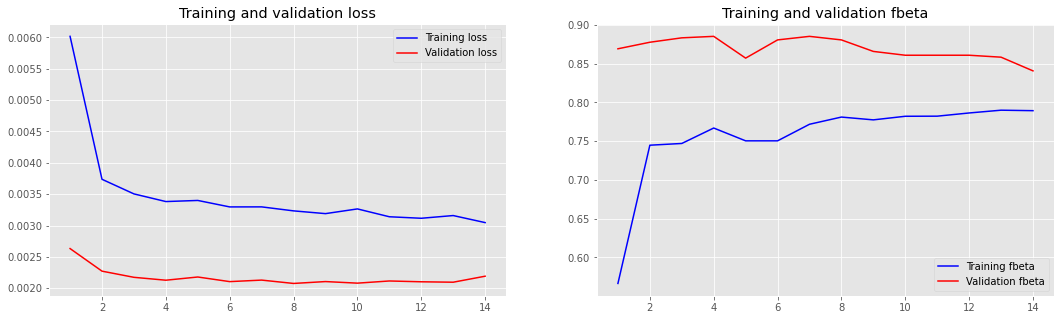

In [34]:
plot_history(history)

### After much tuning, this is the best learning curve we can get. Although it is strange that validation set has better metrics than training set. It appears that it is due to the nature of our data.

In [35]:
# retrieving the best number of epochs
best_n_epochs = int(np.array(history.history['val_stateful_binary_fbeta']).argmax() + 1)
best_n_epochs

4

## Now, we will do our cross validation using the best number of  epochs. We will create a custom transformer to clip outliers and encapsulate the preprocessing steps together with our model in a scikit-learn pipeline.

In [36]:
class ClipOutliers(BaseEstimator, TransformerMixin):
    def __init__(self, lower_percentile=1, upper_percentile=99):
        self.lower_percentile = lower_percentile
        self.upper_percentile = upper_percentile
        
    def fit(self, X, y=None):
        self.a = np.percentile(X, self.lower_percentile, axis=0)
        self.b = np.percentile(X, self.upper_percentile, axis=0)
        
        return self
    
    def transform(self, X):
        self.Xt = np.clip(X, self.a, self.b)
        
        return self.Xt

### Fraud sensitive model

In [37]:
fraud_sensitive_model = KerasClassifier(build_fn=build_model)
fraud_sensitive_scaler = StandardScaler()
fraud_sensitive_clipper = ClipOutliers()

fraud_sensitive_pipe = Pipeline([('scaler', fraud_sensitive_scaler), \
                                 ('clipper', fraud_sensitive_clipper), ('model', fraud_sensitive_model)])

fraud_sensitive_scores = cross_validate(fraud_sensitive_pipe, np.array(X), y, verbose=1, \
                         scoring=['f1', 'average_precision'], cv=cv, return_estimator=True, \
                         error_score='raise', fit_params={'model__epochs': int(best_n_epochs), \
                         'model__batch_size': 512, 'model__verbose': 0})

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   32.3s finished


### Note: we used cross_validate because it can take more than one scoring metrics and it can also return the fitting model for each fold.

In [38]:
fraud_sensitive_results = get_metric_scores(fraud_sensitive_scores, np.array(X))
fraud_sensitive_results

,f1_score,auc_pr,cost_savings
split_1,0.791667,0.770626,0.725500
split_2,0.845188,0.851539,0.758706
split_3,0.836207,0.850878,0.794888
split_4,0.817021,0.804436,0.719705


In [39]:
fraud_sensitive_results.mean()

f1_score        0.822521
auc_pr          0.819370
cost_savings    0.749700
dtype: float64

## Cost sensitive model

### We will now look for the best epoch that best minimize the loss function (cost sensitive binary cross-entropy loss)

In [40]:
stopper2 = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)

In [41]:
model2 = build_model()
history2 = model2.fit(X_train, y_train, epochs=30, batch_size=32, callbacks=[stopper2], \
                validation_data=(X_test, y_test), sample_weight=train_sample_weights, verbose=1)

Epoch 1/30
6676/6676 [==============================] - 23s 3ms/step - loss: 0.5467 - stateful_binary_fbeta: 0.6098 - val_loss: 0.0076 - val_stateful_binary_fbeta: 0.8372
Epoch 2/30
6676/6676 [==============================] - 23s 3ms/step - loss: 0.2282 - stateful_binary_fbeta: 0.5088 - val_loss: 0.0181 - val_stateful_binary_fbeta: 0.4857
Epoch 3/30
6676/6676 [==============================] - 22s 3ms/step - loss: 0.1658 - stateful_binary_fbeta: 0.4482 - val_loss: 0.0123 - val_stateful_binary_fbeta: 0.6606
Epoch 4/30
6676/6676 [==============================] - 23s 3ms/step - loss: 0.2037 - stateful_binary_fbeta: 0.4288 - val_loss: 0.0089 - val_stateful_binary_fbeta: 0.7039
Epoch 5/30
6676/6676 [==============================] - 22s 3ms/step - loss: 0.1626 - stateful_binary_fbeta: 0.4110 - val_loss: 0.0091 - val_stateful_binary_fbeta: 0.7200
Epoch 6/30
6676/6676 [==============================] - 23s 4ms/step - loss: 0.1353 - stateful_binary_fbeta: 0.4590 - val_loss: 0.0107 - val_stat

In [42]:
# retrieving the best number of epochs
best_n_epochs2 = int(np.array(history2.history['val_loss']).argmin() + 1)
best_n_epochs2

7

## Now, we will do our cross validation using the best number of  epochs.

In [43]:
cost_sensitive_model = KerasClassifier(build_fn=build_model)
cost_sensitive_scaler = StandardScaler()
cost_sensitive_clipper = ClipOutliers()

cost_sensitive_pipe = Pipeline([('scaler', cost_sensitive_scaler), \
                                 ('clipper', cost_sensitive_clipper), ('model', cost_sensitive_model)])

cost_sensitive_scores = cross_validate(cost_sensitive_pipe, np.array(X), y, verbose=1, \
                         scoring=['f1', 'average_precision'], cv=cv, return_estimator=True, \
                         error_score='raise', fit_params={'model__epochs': best_n_epochs2, \
                         'model__batch_size': 32, 'model__verbose': 0, \
                         'model__sample_weight': sample_weights})

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  8.5min finished


In [44]:
cost_sensitive_results = get_metric_scores(cost_sensitive_scores, np.array(X))
cost_sensitive_results

,f1_score,auc_pr,cost_savings
split_1,0.501292,0.671125,0.745981
split_2,0.640000,0.746174,0.859478
split_3,0.510101,0.757450,0.833368
split_4,0.592145,0.675804,0.720109


In [45]:
cost_sensitive_results.mean()

f1_score        0.560885
auc_pr          0.712638
cost_savings    0.789734
dtype: float64

## Bayes Mininmum Risk (BMR)

### Note: cost dependent classification is also called Bayes Mininmum Risk.
***see more about BMR [here](https://link.springer.com/article/10.1007/s42452-020-03375-w)***

In [46]:
# defining a function to predict based on the predicting that will minimize the expected cost.
def bmr_predict(model, x, trans_cost):
    prob = model.predict_proba(x)[:, 1]
        
    expected_cost_0 = prob * trans_cost
    expected_cost_1 = (1-prob) * admin_cost
        
    pred = (expected_cost_1 < expected_cost_0).astype(int)
    return pred

### Calculating AUC PR curve is not possible for BMR because predictions are based on minimum expected cost and not on probability. For this reason, we will calculate only f1_score and cost-savings for this model.

In [47]:
def get_bmr_metric_scores(scores, x, y=y, cv_object=cv):
    ind = ['split_'+str(n) for n in range(1, cv_object.n_splits+1)]
    scores_df = pd.DataFrame(index=ind)

    f1_results = []
    cs_results = []
    
    for i, (_, test_ind) in zip(range(cv_object.n_splits), cv_object.split(x, y)):
        amount = df['Amount'].values[test_ind]
        
        ypred = bmr_predict(scores['estimator'][i], x[test_ind], amount)
        ytrue = y[test_ind]
                
        f1_results.append(f1_score(ytrue, ypred))
        cs_results.append(cost_saving(ytrue, ypred, amount))
        
    scores_df['f1_score'] = f1_results
    #scores_df['auc_pr'] = scores['test_average_precision']
    scores_df['cost_savings'] = cs_results

    return scores_df    

In [48]:
bmr_results = get_bmr_metric_scores(fraud_sensitive_scores, np.array(X))
bmr_results

,f1_score,cost_savings
split_1,0.429952,0.714708
split_2,0.420601,0.855550
split_3,0.501377,0.843274
split_4,0.415704,0.788582


In [49]:
bmr_results.mean()

f1_score        0.441909
cost_savings    0.800528
dtype: float64

## We now see that as we make our model more cost sensitive, f1score drops. Overall, fraud sensitive model seems to be the best for MLP since all of the three metrics are pretty good.